<div class="alert-warning">
 <font size="+2"> <b> Raw data alignment </b> </font>
</div>

This tutorial will cover the steps for performing the alignment of raw RNA- and HiFi-sequencing data. You will need to use [the software IGV](https://software.broadinstitute.org/software/igv/download) on your computer to visualize some of the output files, which can be easily downloaded once they are produced. At the end of this tutorial you will be able to:
- perform and discuss quality control on raw data in `fastq` format using `FastQC` and `MultiQC`
- align HiFi and RNA sequencing data with dedicated tools such as `MiniMap2` and `STAR`
- analyze the quality the alignment with `qualimap` 
The output of this notebook will be used for the Variant calling analysis and the bulk RNA-sequencing analysis. If you do not want to run this notebook, you can alternatively use [the free interactive tool Galaxy](https://usegalaxy.org/) to perform the alignment steps. We have uploaded the data on Galaxy, and the manual to perform the exercise is found at the course webpage !!!!!!!!!!!!!!!.

The present tutorial, like the rest of the course material, is available at our [open-source github repository](https://github.com/hds-sandbox/NGS_summer_course_Aarhus.


A few introductory points to run this notebook:

* To use this notebook, use the `NGS (python)` kernel that contains the packages. Choose it by selecting `Kernel -> Change Kernel` in the menu on top of the window.

![image.png](attachment:cf35b6d4-01de-4de3-99c8-1d064f9b52ce.png)

* In this notebook you will use only bash commands as you would do in the command line (this is why you read `%%bash` at the beginning of each piece of code). Those commands can be replicated in the command line, but we thought of integrating them in a notebook to make the tutorial understandable. The bash commands can also be marked with an `!` sign at the beginning of the line
*  You can run the code in each cell by clicking on the run cell button, or by pressing <kbd> Shift </kbd> + <kbd> Enter </kbd>.  When the code is done running, a small green check sign will appear on the left side
*   You need to run the cells in sequential order, please do not run a cell until the one above finished running and do not skip any cells
*   Each cell contains a short description of the code and the output you should get. Please try not to focus on understanding the code for each command in too much detail, but rather try to focus on the output 
*   You can create new code cells by pressing <kbd> + </kbd> in the Menu bar above. 


# Biological background

White clover (Trifolium repens) is an allotetraploid.  It is a relatively young, outcrossing species, which originated during the most recent glaciation around 20,000 years ago by hybridisation of two diploid species, T. occidentale and T. pallescens (see figure below). 

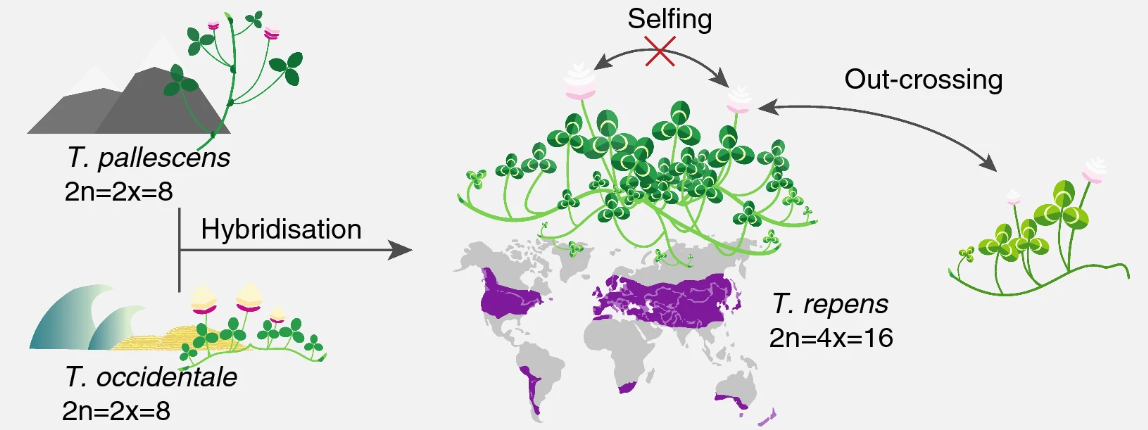

This means that it contains genomes originating from two different species within the same nucleus. Normally, white clover is an outbreeding species, but a self-compatible line was used for sequencing the white clover genome [(Griffiths et al, 2019)](https://academic.oup.com/plcell/article/31/7/1466/5985684). This line will be 
designated as `S10` in the data, indicating that this is the 10th self-fertilized generation. In addition, we have data from a wild clover accession (ecotype) called Tienshan (`Ti`), which is collected from the Chinese mountains and is adapted to alpine conditions.

We will perform alignment of the data to the white clover's reference genome containing both T. occidentale and T. pallescens (called `contig 1` and `contig 2` in the data). We will also perform alignment to each subgenome, and see which are the differences with the quality control tools.

We need to make a link to the command line tools that has been installed on our system. This is usually not necessary when you use those tools on the command line (where you just type the software name to execute it), but it is necessary in our specific setup. 

In [ ]:
%%bash
ln -sf /work/59896/NGS_align/opt/fastqc-0.11.9/fastqc fastqc 
ln -sf /work/59896/NGS_align/bin/multiqc multiqc 
ln -sf /work/59896/NGS_align/bin/minimap2 minimap2
ln -sf /work/59896/NGS_align/bin/qualimap qualimap
ln -sf /work/59896/NGS_align/bin/samtools samtools
ln -sf /work/59896/NGS_align/bin/STAR STAR

Check if the data folder is there

In [5]:
%%bash
sh ../Scripts/dataDownloadScript.sh

Copying datasets from https://zenodo.org/record/6952995


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  145M  100  145M    0     0  1955k      0  0:01:16  0:01:16 --:--:-- 5973k
x Clover_Data/
x Clover_Data/S10_1_1.R1.fastq
x Clover_Data/Hifi_reads_white_clover.fastq
x Clover_Data/DNA_Contig1.fasta
x Clover_Data/TI_1_2.R1.fastq
x Clover_Data/TI_1_1.R2.fastq
x Clover_Data/DNA_Contig1_2.fasta.fai
x Clover_Data/S10_2_2.R1.fastq
x Clover_Data/S10_2_3.R2.fastq
x Clover_Data/Functional_Annotations.txt
x Clover_Data/white_clover_genes.gff
x Clover_Data/TI_2_1.R2.fastq
x Clover_Data/TI_1_3.R2.fastq
x Clover_Data/S10_2_1.R1.fastq
x Clover_Data/DNA_Contig2.fasta
x Clover_Data/DNA_Contig2.fasta.fai
x Clover_Data/TI_2_3.R2.fastq
x Clover_Data/S10_1_2.R2.fastq
x Clover_Data/S10_1_3.R2.fastq
x Clover_Data/TI_2_2.R2.fastq
x Clover_Data/TI_1_1.R1.fastq
x Clover_Data/TI_2_2.R1.fastq
x Clover_Data/metadata.csv
x Clover_Data/TI_2_3.R1.fastq
x Clo

# Quality control and mapping

## Quality Control

We run `FastQC` on the PacBio Hifi reads and on two of the Illumina RNA-seq libraries. `FastQC` does quality control of the raw sequence data, providing an overview of the data which can help identify if there are any problems that should be addressed before further analysis. You can find the report for each file into the folder `results/fastqc_output/`. The output is in HTML format and can be opened in any browser or in `jupyterlab`. It is however not easy to compare the various libraries by opening separate reports. To aggregate all the results, we apply the `MultiQC` software to the reports' folder. The output of MultiQC is in the directory `results/multiqc_output/fastqc_data`.

In [6]:
%%bash
#run fast
mkdir -p results/fastqc_output
./fastqc -q -o results/fastqc_output ../Data/Clover_Data/*.fastq

In [7]:
%%bash
./multiqc --outdir results/multiqc_output/fastqc_data results/fastqc_output


  /// MultiQC 🔍 | v1.13.dev0

|           multiqc | Search path : /Users/bruger/NGS_summer_course_Aarhus/Notebooks/results/fastqc_output
|         searching | ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 50/50  
Unable to revert mtime: /Library/Fonts
Matplotlib is building the font cache; this may take a moment.
|            fastqc | Found 25 reports
|           multiqc | Compressing plot data
|           multiqc | Report      : results/multiqc_output/fastqc_data/multiqc_report.html
|           multiqc | Data        : results/multiqc_output/fastqc_data/multiqc_data
|           multiqc | MultiQC complete


In [8]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [10]:
%%bash
minimap2 --help

Usage: minimap2 [options] <target.fa>|<target.idx> [query.fa] [...]
Options:
  Indexing:
    -H           use homopolymer-compressed k-mer (preferrable for PacBio)
    -k INT       k-mer size (no larger than 28) [15]
    -w INT       minimizer window size [10]
    -I NUM       split index for every ~NUM input bases [4G]
    -d FILE      dump index to FILE []
  Mapping:
    -f FLOAT     filter out top FLOAT fraction of repetitive minimizers [0.0002]
    -g NUM       stop chain enlongation if there are no minimizers in INT-bp [5000]
    -G NUM       max intron length (effective with -xsplice; changing -r) [200k]
    -F NUM       max fragment length (effective with -xsr or in the fragment mode) [800]
    -r NUM[,NUM] chaining/alignment bandwidth and long-join bandwidth [500,20000]
    -n INT       minimal number of minimizers on a chain [3]
    -m INT       minimal chaining score (matching bases minus log gap penalty) [40]
    -X           skip self and dual mappings (for the all-vs-all m

<div class="alert-success"> <font size="+2"> <b> Questions </b> </font> </div>

Visualize the Webpage generated by MultiQC.

Hint: You can find a `Help` button that offers additional information about the plots for each panel. Focus on the following panels: “Per base sequence quality”, “Per sequence quality scores”.... (“Per base sequence content” always gives a `FAIL` for RNA-seq data).

* What do you notice with respect to the sequence quality scores? 
* Are there any other quality issues worth noting?

## Hifi data mapping

We map the PacBio Hifi reads (`Hifi_reads_white_clover.fastq`) to the white clover reference sequence (Contig1&2) using `minimap2`. We run two mapping rounds, using two different preset options (`-x` in the command) for the technology:
* PacBio/Oxford Nanopore read to reference mapping: `map-pb`
* Long assembly to reference mapping. Divergence is far below 5%” settings `asm5`.
Next, we create reports of the mapping results by running `QualiMap` on the two obtained SAM files.

We first need to index the reference fasta files using `samtools faidx`. This produces files in `.fai` format containing informations about length of the reference sequence, offset for the quality scores, name of the reference sequence. [Click here](http://www.htslib.org/doc/faidx.html) for a detailed overview. 

In [1]:
%%bash
./samtools faidx ../Data/Clover_Data/DNA_Contig1_2.fasta
./samtools faidx ../Data/Clover_Data/DNA_Contig1.fasta
./samtools faidx ../Data/Clover_Data/DNA_Contig2.fasta

we create an output folder for the HIFI alignment, and run `minimap2` with the settings explained before.

In [18]:
%%bash 
mkdir -p results/HIFI_alignment/
./minimap2 -a -x map-pb -o results/HIFI_alignment/PacBio_clover_alignment_1_2_mappb.sam \
                            ../Data/Clover_Data/DNA_Contig1_2.fasta \
                            ../Data/Clover_Data/Hifi_reads_white_clover.fastq 

./minimap2 -a -x asm5 -o results/HIFI_alignment/PacBio_clover_alignment_1_2_asm5.sam \
                            ../Data/Clover_Data/DNA_Contig1_2.fasta \
                            ../Data/Clover_Data/Hifi_reads_white_clover.fastq

[M::mm_idx_gen::0.105*0.98] collected minimizers
[M::mm_idx_gen::0.121*1.24] sorted minimizers
[M::main::0.121*1.24] loaded/built the index for 2 target sequence(s)
[M::mm_mapopt_update::0.126*1.23] mid_occ = 11
[M::mm_idx_stat] kmer size: 19; skip: 10; is_hpc: 1; #seq: 2
[M::mm_idx_stat::0.130*1.22] distinct minimizers: 203943 (79.05% are singletons); average occurrences: 1.273; average spacing: 8.047; total length: 2089554
[M::worker_pipeline::26.226*2.35] mapped 4395 sequences
[M::main] Version: 2.24-r1122
[M::main] CMD: minimap2 -a -x map-pb -o results/HIFI_alignment/PacBio_clover_alignment_1_2_mappb.sam ../Data/Clover_Data/DNA_Contig1_2.fasta ../Data/Clover_Data/Hifi_reads_white_clover.fastq
[M::main] Real time: 26.267 sec; CPU: 61.659 sec; Peak RSS: 1.158 GB
[M::mm_idx_gen::0.083*1.08] collected minimizers
[M::mm_idx_gen::0.098*1.37] sorted minimizers
[M::main::0.098*1.37] loaded/built the index for 2 target sequence(s)
[M::mm_mapopt_update::0.102*1.35] mid_occ = 50
[M::mm_idx_st

`samtools sort` is used to sort the alignment with left-to-right coordinates. The output is in `.bam` format, with `.sam` files in input (Note that you could have gotten `.bam` files from `minimap2` with a specific option).

In [19]:
%%bash
samtools sort results/HIFI_alignment/PacBio_clover_alignment_1_2_mappb.sam \
                -o results/HIFI_alignment/PacBio_clover_alignment_1_2_mappb.sort.bam

samtools sort results/HIFI_alignment/PacBio_clover_alignment_1_2_asm5.sam \
                -o results/HIFI_alignment/PacBio_clover_alignment_1_2_asm5.sort.bam

`samtools index` creates the index for the `bam` file, stored in `.bai` format. The index file lets programs access any position into the aligned data without reading the whole file, which would take too much time.

In [20]:
%%bash
./samtools index results/HIFI_alignment/PacBio_clover_alignment_1_2_mappb.sort.bam
./samtools index results/HIFI_alignment/PacBio_clover_alignment_1_2_asm5.sort.bam

Run quality control on both files

In [2]:
 %%bash
qualimap bamqc -bam results/HIFI_alignment/PacBio_clover_alignment_1_2_mappb.sort.bam \
                 -outdir results/qualimap_output/PacBio_clover_alignment_1_2_mappb

qualimap bamqc -bam results/HIFI_alignment/PacBio_clover_alignment_1_2_asm5.sort.bam \
                 -outdir results/qualimap_output/PacBio_clover_alignment_1_2_asm5

Java memory size is set to 1200M
Launching application...

QualiMap v.2.2.2-dev
Built on 2019-11-11 14:05

Selected tool: bamqc
Available memory (Mb): 33
Max memory (Mb): 1258
Fri Aug 05 12:59:03 CEST 2022		WARNING	Output folder already exists, the results will be saved there

Starting bam qc....
Loading sam header...
Loading locator...
Loading reference...
Number of windows: 400, effective number of windows: 401
Chunk of reads size: 1000
Number of threads: 4
Processed 50 out of 401 windows...
Processed 100 out of 401 windows...
Processed 150 out of 401 windows...
Processed 200 out of 401 windows...
Processed 250 out of 401 windows...
Processed 300 out of 401 windows...
Processed 350 out of 401 windows...
Processed 400 out of 401 windows...
Total processed windows:401
Number of reads: 4395
Number of valid reads: 4696
Number of correct strand reads:0

Inside of regions...
Num mapped reads: 4395
Num mapped first of pair: 0
Num mapped second of pair: 0
Num singletons: 0
Time taken to anal

<div class="alert-success"> <font size="+2"> <b> Questions </b> </font> </div>

Visualize the reports generated by QualiMap. If you want, you can also inspect the alignment files in `IGV`. First, you will need to download the reference fasta sequence in `../Data/Clover_Data/DNA_Contig1_2.fasta` and import it into IGV. Go to IGV and use the `Genomes --> Load Genome from file` menu and select the relevant fasta file. Afterwards, to view the alignments directly in IGV click on the Visualize button on the selected dataset (marked in red) and choose the `1. display with IGV (local)` option. You need to have IGV opened locally on your computer. 

* What do you observe when comparing the two BAM files? 
* Which setting do you think is the more appropriate to use, and why?
* Have a look at the polymorphic regions in IGV and think about if they are true polymorphisms.

Next, we map the white clover PacBio Hifi reads to contig1 and contig2 separately, using the setting you selected at the previous step (let's say `map-pb` was chosen, but you are free to change this setting in the commands). As the two contigs represent the two white clover subgenomes, this mapping will allow you to see the two subgenome haplotypes and call subgenome SNPs.


In [3]:
%%bash 
minimap2 -a -x map-pb -o results/HIFI_alignment/PacBio_clover_alignment_1.sam \
                            ../Data/Clover_Data/DNA_Contig1.fasta \
                            ../Data/Clover_Data/Hifi_reads_white_clover.fastq

[M::mm_idx_gen::0.147*0.34] collected minimizers
[M::mm_idx_gen::0.161*0.57] sorted minimizers
[M::main::0.161*0.57] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.164*0.58] mid_occ = 10
[M::mm_idx_stat] kmer size: 19; skip: 10; is_hpc: 1; #seq: 1
[M::mm_idx_stat::0.166*0.58] distinct minimizers: 112547 (91.45% are singletons); average occurrences: 1.141; average spacing: 8.031; total length: 1031631
[M::worker_pipeline::46.892*2.63] mapped 4395 sequences
[M::main] Version: 2.24-r1122
[M::main] CMD: minimap2 -a -x map-pb -o results/HIFI_alignment/PacBio_clover_alignment_1.sam ../Data/Clover_Data/DNA_Contig1.fasta ../Data/Clover_Data/Hifi_reads_white_clover.fastq
[M::main] Real time: 46.923 sec; CPU: 123.248 sec; Peak RSS: 2.179 GB


In [4]:
%%bash 
minimap2 -a -x map-pb -o results/HIFI_alignment/PacBio_clover_alignment_2.sam \
                            ../Data/Clover_Data/DNA_Contig2.fasta \
                            ../Data/Clover_Data/Hifi_reads_white_clover.fastq

[M::mm_idx_gen::0.078*0.66] collected minimizers
[M::mm_idx_gen::0.090*0.97] sorted minimizers
[M::main::0.090*0.97] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.094*0.97] mid_occ = 10
[M::mm_idx_stat] kmer size: 19; skip: 10; is_hpc: 1; #seq: 1
[M::mm_idx_stat::0.096*0.97] distinct minimizers: 120722 (93.18% are singletons); average occurrences: 1.087; average spacing: 8.062; total length: 1057923
[M::worker_pipeline::45.554*2.74] mapped 4395 sequences
[M::main] Version: 2.24-r1122
[M::main] CMD: minimap2 -a -x map-pb -o results/HIFI_alignment/PacBio_clover_alignment_2.sam ../Data/Clover_Data/DNA_Contig2.fasta ../Data/Clover_Data/Hifi_reads_white_clover.fastq
[M::main] Real time: 45.585 sec; CPU: 124.885 sec; Peak RSS: 1.880 GB


Sort the bam files and create their index using `samtools`

In [5]:
%%bash
samtools sort results/HIFI_alignment/PacBio_clover_alignment_1.sam -o results/HIFI_alignment/PacBio_clover_alignment_1.sort.bam
samtools sort results/HIFI_alignment/PacBio_clover_alignment_2.sam -o results/HIFI_alignment/PacBio_clover_alignment_2.sort.bam

In [6]:
%%bash
samtools index results/HIFI_alignment/PacBio_clover_alignment_1.sort.bam
samtools index results/HIFI_alignment/PacBio_clover_alignment_2.sort.bam

Perform quality control

In [8]:
%%bash
mkdir -p results/qualimap_output
qualimap bamqc -bam results/HIFI_alignment/PacBio_clover_alignment_1.sort.bam -outdir results/qualimap_output/PacBio_clover_alignment_1

Java memory size is set to 1200M
Launching application...

QualiMap v.2.2.2-dev
Built on 2019-11-11 14:05

Selected tool: bamqc
Available memory (Mb): 33
Max memory (Mb): 1258
Starting bam qc....
Loading sam header...
Loading locator...
Loading reference...
Number of windows: 400, effective number of windows: 400
Chunk of reads size: 1000
Number of threads: 4
Processed 50 out of 400 windows...
Processed 100 out of 400 windows...
Processed 150 out of 400 windows...
Processed 200 out of 400 windows...
Processed 250 out of 400 windows...
Processed 300 out of 400 windows...
Processed 350 out of 400 windows...
Processed 400 out of 400 windows...
Total processed windows:400
Number of reads: 4395
Number of valid reads: 9070
Number of correct strand reads:0

Inside of regions...
Num mapped reads: 4356
Num mapped first of pair: 0
Num mapped second of pair: 0
Num singletons: 0
Time taken to analyze reads: 9
Computing descriptors...
numberOfMappedBases: 59058058
referenceSize: 1031631
numberOfSeq

In [9]:
%%bash
qualimap bamqc -bam results/HIFI_alignment/PacBio_clover_alignment_2.sort.bam -outdir results/qualimap_output/PacBio_clover_alignment_2

Java memory size is set to 1200M
Launching application...

QualiMap v.2.2.2-dev
Built on 2019-11-11 14:05

Selected tool: bamqc
Available memory (Mb): 33
Max memory (Mb): 1258
Starting bam qc....
Loading sam header...
Loading locator...
Loading reference...
Number of windows: 400, effective number of windows: 400
Chunk of reads size: 1000
Number of threads: 4
Processed 50 out of 400 windows...
Processed 100 out of 400 windows...
Processed 150 out of 400 windows...
Processed 200 out of 400 windows...
Processed 250 out of 400 windows...
Processed 300 out of 400 windows...
Processed 350 out of 400 windows...
Processed 400 out of 400 windows...
Total processed windows:400
Number of reads: 4395
Number of valid reads: 9462
Number of correct strand reads:0

Inside of regions...
Num mapped reads: 4394
Num mapped first of pair: 0
Num mapped second of pair: 0
Num singletons: 0
Time taken to analyze reads: 10
Computing descriptors...
numberOfMappedBases: 59388453
referenceSize: 1057923
numberOfSe

<div class="alert-success"> <font size="+2"> <b> Questions </b> </font> </div>

Visualize all three alignments (HiFi reads mapped to Contigs1_2, contig1 and contig2) in IGV. If you want to load BAM files in IGV directly from your computer, you will also need to index the
files.

* Why do you see fluctuations in coverage and large regions without any apparent subgenome SNPs?
* What are the major differences between the stats for the reads mapped to Contigs1&2 versus contig1 and contig2? What is your interpretation of the differences?

# RNA-seq mapping

In the `../Data` folder you will find 24 RNA-seq libraries, 12 `S10` libraries and 12  `Tienshan` libraries. Each library is paired-end, which is denoted by `R1` and `R2` at the end of two files having the same name, such as `S10_1_1.R1.fastq` and `S10_1_1.R2.fastq`. We will align each library separately and then merge the alignments to create two final samples for `S10` and `Tienshan`.

First, we need to create a genome file for the reference fasta file of contigs `1` and `2`. This is done with `STAR`, using the option `--runMode genomeGenerate`. Look at the code for reading what other option are for. `STAR` is a very complex tool with many options, so it is always useful to [have a reference manual](https://physiology.med.cornell.edu/faculty/skrabanek/lab/angsd/lecture_notes/STARmanual.pdf).

In [11]:
%%bash
STAR --runThreadN 8 \
--runMode genomeGenerate \
--genomeDir results/STAR_output/indexing_contigs_1_2 \
--genomeFastaFiles ../Data/Clover_Data/DNA_Contig1_2.fasta \
--sjdbGTFfile ../Data/Clover_Data/white_clover_genes.gff \
--quantMode GeneCounts

	STAR --runThreadN 8 --runMode genomeGenerate --genomeDir results/STAR_output/indexing_contigs_1_2 --genomeFastaFiles ../Data/Clover_Data/DNA_Contig1_2.fasta --sjdbGTFfile ../Data/Clover_Data/white_clover_genes.gff --quantMode GeneCounts
	STAR version: 2.7.10a   compiled:  :/Users/travis/build/alexdobin/travis-tests/STARcompile/source
Aug 05 13:03:50 ..... started STAR run
Aug 05 13:03:50 ... starting to generate Genome files
Aug 05 13:03:50 ..... processing annotations GTF
Aug 05 13:03:50 ... starting to sort Suffix Array. This may take a long time...
Aug 05 13:03:50 ... sorting Suffix Array chunks and saving them to disk...
Aug 05 13:03:51 ... loading chunks from disk, packing SA...
Aug 05 13:03:51 ... finished generating suffix array
Aug 05 13:03:51 ... generating Suffix Array index
Aug 05 13:03:55 ... completed Suffix Array index
Aug 05 13:03:55 ... writing Genome to disk ...
Aug 05 13:03:55 ... writing Suffix Array to disk ...
Aug 05 13:03:56 ... writing SAindex to disk
Aug 05 13:

!!!!! WARNING: --genomeSAindexNbases 14 is too large for the genome size=2089554, which may cause seg-fault at the mapping step. Re-run genome generation with recommended --genomeSAindexNbases 9


We got a warning saying
```
!!!!! WARNING: --genomeSAindexNbases 14 is too large for the genome size=2089554, which may cause seg-fault at the mapping step. Re-run genome generation with recommended --genomeSAindexNbases 9
```
so we rerun the command with the suggested option.

In [38]:
%%bash
STAR --runThreadN 8 \
--runMode genomeGenerate \
--genomeDir results/STAR_output/indexing_contigs_1_2 \
--genomeFastaFiles ../Data/Clover_Data/DNA_Contig1_2.fasta \
--sjdbGTFfile ../Data/Clover_Data/white_clover_genes.gff \
--quantMode GeneCounts \
--genomeSAindexNbases 9 

	STAR --runThreadN 8 --runMode genomeGenerate --genomeDir results/STAR_output/indexing_contigs_1_2 --genomeFastaFiles ../Data/Clover_Data/DNA_Contig1_2.fasta --sjdbGTFfile ../Data/Clover_Data/white_clover_genes.gff --quantMode GeneCounts --genomeSAindexNbases 9
	STAR version: 2.7.10a   compiled:  :/Users/travis/build/alexdobin/travis-tests/STARcompile/source
Aug 05 13:29:32 ..... started STAR run
Aug 05 13:29:32 ... starting to generate Genome files
Aug 05 13:29:32 ..... processing annotations GTF
Aug 05 13:29:32 ... starting to sort Suffix Array. This may take a long time...
Aug 05 13:29:32 ... sorting Suffix Array chunks and saving them to disk...
Aug 05 13:29:33 ... loading chunks from disk, packing SA...
Aug 05 13:29:34 ... finished generating suffix array
Aug 05 13:29:34 ... generating Suffix Array index
Aug 05 13:29:34 ... completed Suffix Array index
Aug 05 13:29:34 ... writing Genome to disk ...
Aug 05 13:29:34 ... writing Suffix Array to disk ...
Aug 05 13:29:34 ... writing SA

We use again `STAR` to align every single library for `S10`. We extract the library name of each file and run STAR through each pair of files. Note that plant introns are very rarely more than `5000 bp` and that you are mapping to two homoeologous contigs that show high similarity, especially in genic regions. We set the maximum size to 5000 using `--alignIntronMax 5000`.

In [27]:
!ls -lh ../Data/Clover_Data/S10*.R1.fastq

-rw-rw-rw-  1 bruger  staff    18M  2 Aug 14:05 ../Data/Clover_Data/S10_1_1.R1.fastq
-rw-rw-rw-  1 bruger  staff    24M  2 Aug 14:05 ../Data/Clover_Data/S10_1_2.R1.fastq
-rw-rw-rw-  1 bruger  staff    26M  2 Aug 14:05 ../Data/Clover_Data/S10_1_3.R1.fastq
-rw-rw-rw-  1 bruger  staff    25M  2 Aug 14:05 ../Data/Clover_Data/S10_2_1.R1.fastq
-rw-rw-rw-  1 bruger  staff    23M  2 Aug 14:05 ../Data/Clover_Data/S10_2_2.R1.fastq
-rw-rw-rw-  1 bruger  staff    27M  2 Aug 14:06 ../Data/Clover_Data/S10_2_3.R1.fastq


In [35]:
!chmod 777 results/STAR_output/indexing_contigs_1_2/
!chmod 777 results/STAR_output/S10_align_contigs_1_2/

In [40]:
%%bash
for i in `ls ../Data/Clover_Data/S10*.R1.fastq`
do

PREFIXNAME=`basename $i .R1.fastq`
echo "###############################################"
echo "##### ALIGNING PAIRED-END READS "$PREFIXNAME
echo "###############################################"
STAR --genomeDir results/STAR_output/indexing_contigs_1_2/ \
--runThreadN 8 \
--readFilesIn ../Data/Clover_Data/$PREFIXNAME.R1.fastq ../Data/Clover_Data/$PREFIXNAME.R2.fastq \
--outFileNamePrefix results/STAR_output/S10_align_contigs_1_2/$PREFIXNAME \
--outSAMtype BAM SortedByCoordinate \
--outSAMattributes Standard \
--sjdbGTFfile ../Data/Clover_Data/white_clover_genes.gff \
--quantMode GeneCounts \
--alignIntronMax 5000 \
--genomeSAindexNbases 9 

done

###############################################
##### ALIGNING PAIRED-END READS S10_1_1
###############################################
Aug 05 13:36:14 ..... started STAR run
Aug 05 13:36:14 ..... loading genome
Aug 05 13:36:14 ..... processing annotations GTF
Aug 05 13:36:14 ..... started mapping
Aug 05 13:36:20 ..... finished mapping
Aug 05 13:36:20 ..... started sorting BAM
Aug 05 13:36:21 ..... finished successfully
###############################################
##### ALIGNING PAIRED-END READS S10_1_2
###############################################
Aug 05 13:36:21 ..... started STAR run
Aug 05 13:36:21 ..... loading genome
Aug 05 13:36:21 ..... processing annotations GTF
Aug 05 13:36:21 ..... started mapping
Aug 05 13:36:30 ..... finished mapping
Aug 05 13:36:30 ..... started sorting BAM
Aug 05 13:36:31 ..... finished successfully
###############################################
##### ALIGNING PAIRED-END READS S10_1_3
###############################################
Aug 05 13:36:32 

Do the same alignment for `Tienshan` libraries

In [41]:
%%bash
for i in `ls ../Data/Clover_Data/TI*.R1.fastq`
do

PREFIXNAME=`basename $i .R1.fastq`
echo "###############################################"
echo "##### ALIGNING PAIRED-END READS "$PREFIXNAME
echo "###############################################"
STAR --genomeDir results/STAR_output/indexing_contigs_1_2/ \
--runThreadN 8 \
--readFilesIn ../Data/Clover_Data/$PREFIXNAME.R1.fastq ../Data/Clover_Data/$PREFIXNAME.R2.fastq \
--outFileNamePrefix results/STAR_output/TI_align_contigs_1_2/$PREFIXNAME \
--outSAMtype BAM SortedByCoordinate \
--outSAMattributes Standard \
--sjdbGTFfile ../Data/Clover_Data/white_clover_genes.gff \
--quantMode GeneCounts \
--alignIntronMax 5000 \
--genomeSAindexNbases 9

done

###############################################
##### ALIGNING PAIRED-END READS TI_1_1
###############################################
Aug 05 13:37:38 ..... started STAR run
Aug 05 13:37:38 ..... loading genome
Aug 05 13:37:38 ..... processing annotations GTF
Aug 05 13:37:38 ..... started mapping
Aug 05 13:37:48 ..... finished mapping
Aug 05 13:37:48 ..... started sorting BAM
Aug 05 13:37:49 ..... finished successfully
###############################################
##### ALIGNING PAIRED-END READS TI_1_2
###############################################
Aug 05 13:37:49 ..... started STAR run
Aug 05 13:37:49 ..... loading genome
Aug 05 13:37:49 ..... processing annotations GTF
Aug 05 13:37:49 ..... started mapping
Aug 05 13:37:59 ..... finished mapping
Aug 05 13:37:59 ..... started sorting BAM
Aug 05 13:38:00 ..... finished successfully
###############################################
##### ALIGNING PAIRED-END READS TI_1_3
###############################################
Aug 05 13:38:00 ...

Run quality control on each aligned library with `MultiQC`. In this way there will be a whole report to compare `S10` files and `Tienshan` files.

In [42]:
%%bash
multiqc --outdir results/multiqc_output/TI_STAR_align_1_2 \
            results/STAR_output/TI_align_contigs_1_2/


  /// MultiQC 🔍 | v1.13.dev0

|           multiqc | Search path : /Users/bruger/NGS_summer_course_Aarhus_opensource/Notebooks/results/STAR_output/TI_align_contigs_1_2
|         searching | ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 738/738  
|              star | Found 6 reports and 6 gene count files
|           multiqc | Compressing plot data
|           multiqc | Report      : results/multiqc_output/TI_STAR_align_1_2/multiqc_report.html
|           multiqc | Data        : results/multiqc_output/TI_STAR_align_1_2/multiqc_data
|           multiqc | MultiQC complete


In [43]:
%%bash
multiqc --outdir results/multiqc_output/S10_STAR_align_1_2 \
            results/STAR_output/S10_align_contigs_1_2/


  /// MultiQC 🔍 | v1.13.dev0

|           multiqc | Search path : /Users/bruger/NGS_summer_course_Aarhus_opensource/Notebooks/results/STAR_output/S10_align_contigs_1_2
|         searching | ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 84/84  
|              star | Found 6 reports and 6 gene count files
|           multiqc | Compressing plot data
|           multiqc | Report      : results/multiqc_output/S10_STAR_align_1_2/multiqc_report.html
|           multiqc | Data        : results/multiqc_output/S10_STAR_align_1_2/multiqc_data
|           multiqc | MultiQC complete


We merge the outputs of each group of aligned libraries. Here is how the files look like for the `Tienshan`.

In [44]:
!ls -lh  results/STAR_output/TI_align_contigs_1_2/TI_*.sortedByCoord.out.bam 

-rwxrwxrwx  1 bruger  staff   6.6M  5 Aug 13:37 results/STAR_output/TI_align_contigs_1_2/TI_1_1Aligned.sortedByCoord.out.bam
-rwxrwxrwx  1 bruger  staff   6.0M  5 Aug 13:38 results/STAR_output/TI_align_contigs_1_2/TI_1_2Aligned.sortedByCoord.out.bam
-rwxrwxrwx  1 bruger  staff   7.1M  5 Aug 13:38 results/STAR_output/TI_align_contigs_1_2/TI_1_3Aligned.sortedByCoord.out.bam
-rwxrwxrwx  1 bruger  staff   9.6M  5 Aug 13:38 results/STAR_output/TI_align_contigs_1_2/TI_2_1Aligned.sortedByCoord.out.bam
-rwxrwxrwx  1 bruger  staff   7.1M  5 Aug 13:38 results/STAR_output/TI_align_contigs_1_2/TI_2_2Aligned.sortedByCoord.out.bam
-rwxrwxrwx  1 bruger  staff   8.2M  5 Aug 13:38 results/STAR_output/TI_align_contigs_1_2/TI_2_3Aligned.sortedByCoord.out.bam


Apply `samtools merge`

In [45]:
%%bash
mkdir -p results/STAR_output/TI_align_contigs_1_2_merge/
samtools merge -fo results/STAR_output/TI_align_contigs_1_2_merge/TI.sorted.bam results/STAR_output/TI_align_contigs_1_2/TI_*.sortedByCoord.out.bam 

In [46]:
%%bash
mkdir -p results/STAR_output/S10_align_contigs_1_2_merge/
samtools merge -fo results/STAR_output/S10_align_contigs_1_2_merge/S10.sorted.bam results/STAR_output/S10_align_contigs_1_2/S10_*.sortedByCoord.out.bam 

Index both merging outputs

In [47]:
%%bash
samtools index results/STAR_output/S10_align_contigs_1_2_merge/S10.sorted.bam results/STAR_output/TI_align_contigs_1_2_merge/TI.sorted.bam

# Wrapping up  🎉 🎉 🎉

In this exercise, you learnt to align various types of data after performing quality control for raw data. We looked at some of the options for the aligners and at how to use some of the basic samtools manipulation programs. The outputs from the RNA alignments will be used for the VCF file analysis in the next notebook, and the RNA alignments will be use for the bulk RNA data analysis.

